In [2]:
import glob 
import time
import os 

import numpy as np
import pandas as pd 

import h2o

from h2o.estimators.random_forest import H2ORandomForestEstimator

from sklearn.metrics import mean_absolute_error, mean_squared_error

from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

import matplotlib.pyplot as plt


In [3]:
col_names = ['yyyy', 'mm', 'dd', 'HH', 'LON', 'LAT', 'Pres(hpa)', 'T(Celcius)', 'SST(Celcius)', 'RH(%)', 'u(m/s)', 'v(m/s)', 'WS(m/s)', 'WD(degrees)', 'q(g/kg)', 'dq(g/kg)', 'ASTD(Celcius)', 'RiB', 'EDH(m)']


df = pd.concat([pd.read_csv(f, header=None, names = col_names, sep = '\s+') for f in glob.glob('data/*.txt')], ignore_index = True, sort = False)

print(df.shape)


(6120516, 19)


In [4]:
df.head()

,yyyy,mm,dd,HH,LON,LAT,Pres(hpa),T(Celcius),SST(Celcius),RH(%),u(m/s),v(m/s),WS(m/s),WD(degrees),q(g/kg),dq(g/kg),ASTD(Celcius),RiB,EDH(m)
0,2015,10,13,0,-76.7401,34.8289,1008.15,18.86,19.72,94.00,-0.06,0.81,0.82,175.97,12.63,1.26,-0.85,0.86,0.0
1,2015,10,13,1,-76.7178,34.8293,1008.20,18.78,19.72,93.98,-0.09,0.83,0.84,173.90,12.56,1.32,-0.94,1.03,0.0
2,2015,10,13,2,-76.6955,34.8297,1008.26,18.69,19.65,93.99,-0.18,0.81,0.83,167.29,12.50,1.34,-0.96,1.28,0.0
3,2015,10,13,3,-76.6732,34.8300,1008.31,18.60,19.60,94.06,-0.21,0.90,0.92,166.58,12.43,1.36,-1.00,1.58,0.0
4,2015,10,13,4,-76.6509,34.8304,1008.33,18.49,19.53,93.98,-0.25,0.91,0.95,164.80,12.34,1.39,-1.04,2.14,0.0


In [5]:
sorted(os.listdir('data'))

['NRL_COAMPS_CASPER_EAST_2015101300.txt',
 'NRL_COAMPS_CASPER_EAST_2015101312.txt',
 'NRL_COAMPS_CASPER_EAST_2015101400.txt',
 'NRL_COAMPS_CASPER_EAST_2015101412.txt',
 'NRL_COAMPS_CASPER_EAST_2015101500.txt',
 'NRL_COAMPS_CASPER_EAST_2015101512.txt',
 'NRL_COAMPS_CASPER_EAST_2015101600.txt',
 'NRL_COAMPS_CASPER_EAST_2015101612.txt',
 'NRL_COAMPS_CASPER_EAST_2015101700.txt',
 'NRL_COAMPS_CASPER_EAST_2015101712.txt',
 'NRL_COAMPS_CASPER_EAST_2015101800.txt',
 'NRL_COAMPS_CASPER_EAST_2015102012.txt',
 'NRL_COAMPS_CASPER_EAST_2015102100.txt',
 'NRL_COAMPS_CASPER_EAST_2015102200.txt',
 'NRL_COAMPS_CASPER_EAST_2015102212.txt',
 'NRL_COAMPS_CASPER_EAST_2015102300.txt',
 'NRL_COAMPS_CASPER_EAST_2015102312.txt',
 'NRL_COAMPS_CASPER_EAST_2015102400.txt',
 'NRL_COAMPS_CASPER_EAST_2015102412.txt',
 'NRL_COAMPS_CASPER_EAST_2015102500.txt',
 'NRL_COAMPS_CASPER_EAST_2015102512.txt',
 'NRL_COAMPS_CASPER_EAST_2015102600.txt',
 'NRL_COAMPS_CASPER_EAST_2015102612.txt',
 'NRL_COAMPS_CASPER_EAST_201510270

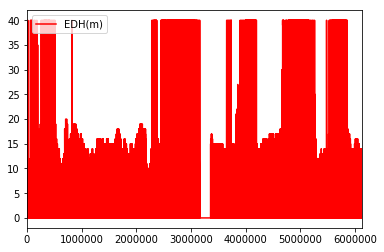

In [6]:
df.plot(kind = 'line', y = 'EDH(m)', color = 'red')

In [7]:
df.isnull().any()

yyyy             False
mm               False
dd               False
HH               False
LON              False
LAT              False
Pres(hpa)        False
T(Celcius)       False
SST(Celcius)     False
RH(%)            False
u(m/s)           False
v(m/s)           False
WS(m/s)          False
WD(degrees)      False
q(g/kg)          False
dq(g/kg)          True
ASTD(Celcius)    False
RiB              False
EDH(m)           False
dtype: bool

In [8]:
df.max()

yyyy             2.015000e+03
mm               1.000000e+01
dd               3.000000e+01
HH               2.300000e+01
LON             -7.386330e+01
LAT              3.718000e+01
Pres(hpa)        1.030210e+03
T(Celcius)       2.645000e+01
SST(Celcius)     3.334000e+01
RH(%)            1.000300e+02
u(m/s)           1.495000e+01
v(m/s)           1.473000e+01
WS(m/s)          1.750000e+01
WD(degrees)      3.600000e+02
q(g/kg)                   inf
dq(g/kg)                  inf
ASTD(Celcius)    2.971500e+02
RiB              1.510094e+06
EDH(m)           4.000000e+01
dtype: float64

In [9]:
df.min()

yyyy             2.015000e+03
mm               1.000000e+01
dd               1.300000e+01
HH               0.000000e+00
LON             -7.680440e+01
LAT              3.482890e+01
Pres(hpa)        0.000000e+00
T(Celcius)      -2.731500e+02
SST(Celcius)    -2.731500e+02
RH(%)            1.786000e+01
u(m/s)          -1.304000e+01
v(m/s)          -1.438000e+01
WS(m/s)          0.000000e+00
WD(degrees)      0.000000e+00
q(g/kg)          2.160000e+00
dq(g/kg)        -4.090000e+00
ASTD(Celcius)   -1.748000e+01
RiB             -2.059190e+08
EDH(m)           0.000000e+00
dtype: float64

In [10]:
df = df.replace([-np.inf, np.inf], np.nan)

In [11]:
df = df.dropna()

In [12]:
df.max()

yyyy             2.015000e+03
mm               1.000000e+01
dd               3.000000e+01
HH               2.300000e+01
LON             -7.386330e+01
LAT              3.718000e+01
Pres(hpa)        1.030210e+03
T(Celcius)       2.645000e+01
SST(Celcius)     3.334000e+01
RH(%)            1.000300e+02
u(m/s)           1.495000e+01
v(m/s)           1.473000e+01
WS(m/s)          1.750000e+01
WD(degrees)      3.600000e+02
q(g/kg)          1.734000e+01
dq(g/kg)         2.231000e+01
ASTD(Celcius)    8.800000e+00
RiB              1.510094e+06
EDH(m)           4.000000e+01
dtype: float64

In [13]:
df.min()

yyyy             2.015000e+03
mm               1.000000e+01
dd               1.300000e+01
HH               0.000000e+00
LON             -7.680440e+01
LAT              3.482890e+01
Pres(hpa)        1.000280e+03
T(Celcius)       3.060000e+00
SST(Celcius)     2.070000e+00
RH(%)            1.786000e+01
u(m/s)          -1.304000e+01
v(m/s)          -1.438000e+01
WS(m/s)          0.000000e+00
WD(degrees)      0.000000e+00
q(g/kg)          2.160000e+00
dq(g/kg)        -4.090000e+00
ASTD(Celcius)   -1.748000e+01
RiB             -2.059190e+08
EDH(m)           0.000000e+00
dtype: float64

In [14]:
df.isnull().any()

yyyy             False
mm               False
dd               False
HH               False
LON              False
LAT              False
Pres(hpa)        False
T(Celcius)       False
SST(Celcius)     False
RH(%)            False
u(m/s)           False
v(m/s)           False
WS(m/s)          False
WD(degrees)      False
q(g/kg)          False
dq(g/kg)         False
ASTD(Celcius)    False
RiB              False
EDH(m)           False
dtype: bool

In [15]:
df.shape

(5923080, 19)

In [16]:
h2o.init(max_mem_size = 12)

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,4 days 23 hours 25 mins
H2O cluster timezone:,America/Los_Angeles
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.2
H2O cluster version age:,"1 year, 3 months and 19 days !!!"
H2O cluster name:,H2O_from_python_denny_3pg9fi
H2O cluster total nodes:,1
H2O cluster free memory:,0
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"locked, healthy"


In [17]:
# converting into H2O dataframe 

hf = h2o.H2OFrame(df)



/Users/denny/anaconda3/envs/EDH_ML/lib/python3.6/site-packages/h2o/utils/shared_utils.py:170: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data = _handle_python_lists(python_obj.as_matrix().tolist(), -1)[1]


H2OServerError: HTTP 500 Server Error:
'<html>\n<head>\n<meta http-equiv="Content-Type" content="text/html;charset=ISO-8859-1"/>\n<title>Error 500 Server Error</title>\n</head>\n<body>\n<h2>HTTP ERROR: 500</h2>\n<p>Problem accessing /3/PostFile. Reason:\n<pre>    Server Error</pre></p>\n<hr /><i><small>Powered by Jetty://</small></i>\n                                                \n                                                \n                                                \n                                                \n                                                \n                                                \n                                                \n                                                \n                                                \n                                                \n                                                \n                                                \n                                                \n                                                \n                                                \n                                                \n                                                \n                                                \n                                                \n                                                \n</body>\n</html>\n'

In [ ]:
x = hf.columns
y = 'EDH(m)'
x.remove(y)

print(x)
print(y)


In [ ]:
hf_train, hf_test = hf.split_frame(ratios = [0.8])

print(len(hf_train))
print(len(hf_test))

hf_train.nrow + hf_test.nrow == hf.nrow


In [ ]:
edh_rf = H2ORandomForestEstimator(max_depth = 50, min_rows = 1, min_split_improvement = 1e-10, ntrees = 200)

In [ ]:
edh_rf.train(x = x, y = y, training_frame = hf_train)

In [ ]:
edh_rf

In [ ]:
edh_perf = edh_rf.model_performance(hf_test)
edh_perf